2025-11-02 12:37:07.832157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762087027.858903    1155 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762087027.865567    1155 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762087027.892715    1155 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762087027.892741    1155 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762087027.892743    1155 computation_placer.cc:177] computation placer alr

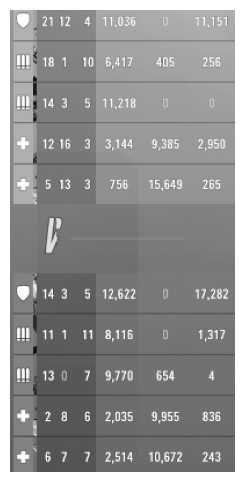

00211204110360000011151011801100641700405002560114030511218000000000002121603031440938502950020513030075615649002651014030512622000001728211110111081160000001317111300070977000654000041202080602035099550083612060707025141067200243


2025-11-02 12:37:20.641470: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
from pandas import CategoricalDtype, read_csv, DataFrame
import pandas as pd
from math import floor, log10
from pathlib import Path
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.image import decode_png, resize
from tensorflow.io import read_file
import tensorflow as tf
from matplotlib.pyplot import figure, axis, imshow, show

# =============================
# 설정
# =============================

RESULTS = 'DEFEAT', 'DRAW', 'VICTORY'
DTYPES = {
    'TEAM': 'uint8',
    'ROLE': CategoricalDtype(('TANK', 'DAMAGE', 'SUPPORT')),
    'E': 'uint8',
    'A': 'uint8',
    'D': 'uint8',
    'DMG': 'uint16',
    'H': 'uint16',
    'MIT': 'uint16'
}
ROLES = ('TANK', 1), ('DAMAGE', 2), ('SUPPORT', 2)
TEAMS = 1, 2
NUMERIC_COLS = [c for c in DTYPES if c not in {'TEAM', 'ROLE'}]

# =============================
# 데이터 로드 및 보정
# =============================

"""ROLE 폴더 내의 CSV 파일들을 모두 로드."""
df = pd.concat(
    (pd.read_csv(f'ROLE/{res}.csv', index_col=0, dtype=DTYPES) for res in RESULTS),
    keys=RESULTS,
    names=('RESULT',)
)
df.dropna(inplace=True)


def fill_missing_roles(group: DataFrame) -> DataFrame:
    """각 TEAM별 ROLE 조합이 빠졌을 때 0으로 채운 행 추가."""
    filled = {col: [] for col in DTYPES}
    for team in TEAMS:
        team_data = group[group['TEAM'] == team]
        for role_name, count in ROLES:
            missing = count - sum(team_data['ROLE'] == role_name)
            for _ in range(missing):
                filled['TEAM'].append(team)
                filled['ROLE'].append(role_name)
                for col in NUMERIC_COLS:
                    filled[col].append(0)
    return DataFrame(filled).astype(DTYPES)


"""누락된 ROLE 채우기 및 정렬."""
df_filled = pd.concat([df, df.groupby(level=(0, 1), group_keys=True).apply(fill_missing_roles)])
df_filled.sort_values(['RESULT', 'INDEX', 'TEAM', 'ROLE'], inplace=True)

# =============================
# 수치 데이터 -> 벡터화
# =============================

"""자리수 단위로 쪼개어 숫자 벡터로 변환."""
encoded = DataFrame()
encoded['TEAM'] = df_filled['TEAM'] - 1
encoded['ROLE'] = df_filled['ROLE'].cat.codes.astype('uint8')

for col in NUMERIC_COLS:
    max_val = df_filled[col].max()
    digits = floor(log10(max_val))
    for d in range(digits, -1, -1):
        encoded[f'{col}{d}'] = (df_filled[col] // 10 ** d % 10).astype('uint8')

df_vector = tuple(encoded.to_numpy().reshape(-1, 230).T)


# =============================
# 이미지 처리
# =============================

def load_and_preprocess_image(img_path: str, label):
    """PNG 이미지를 읽고, 지정 영역 crop + resize."""
    img = decode_png(read_file(img_path), channels=1)[230:930, 530:1370]
    crops = tf.concat([
        img[:, :40],
        img[:, 390:420],
        img[:, 450:480],
        img[:, 500:530],
        img[:, 570:640],
        img[:, 670:740],
        img[:, 770:]
    ], axis=1)
    img_resized = resize(crops, (400, 400), preserve_aspect_ratio=True) / 255
    return img_resized, label


# =============================
# Dataset 구성
# =============================

img_paths = sorted(map(str, Path().rglob('*.png')))
dataset_size = len(df_vector[0])
dataset = (
    Dataset
    .from_tensor_slices((img_paths, df_vector))
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .shuffle(dataset_size)
)
split = int(dataset_size * .9)
train_ds = dataset.take(split).batch(32).prefetch(AUTOTUNE)
val_ds = dataset.skip(split).batch(32).prefetch(AUTOTUNE)

# =============================
# 시각화 테스트
# =============================

for images, labels in train_ds.take(1):
    figure(figsize=(6, 6))
    axis('off')
    imshow(images[0], cmap='gray')
    show()
    print(*(lbl[0].numpy() for lbl in labels), sep='')

In [2]:
shape = images.shape[1:]
nunique = encoded.nunique()
len_labels = len(labels)

In [49]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

clear_session()
inputs = Input(shape)
conv2d = Conv2D(32, (3, 3), activation='relu')(inputs)
max_pooling2d = MaxPooling2D()(conv2d)
conv2d_1 = Conv2D(64, (3, 3), activation='relu')(max_pooling2d)
max_pooling2d_1 = MaxPooling2D()(conv2d_1)
flatten = Flatten()(max_pooling2d_1)
dense = Dense(128, 'relu')(flatten)
outputs = tuple(Dense(nunique[index], 'softmax', name=f'{index}_{i}')(dense) for i in range(10) for index in nunique.index)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 400, 194,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 398, 192,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 199, 96,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 197, 94,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 98, 47,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 294784)    │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 37,732,480 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ TEAM_0 (Dense)      │ (None, 2)         │        258 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ROLE_0 (Dense)      │ (None, 3)         │        387 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ E1_0 (Dense)        │ (None, 6)         │        774 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ E0_0 (Dense)        │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A1_0 (Dense)        │ (None, 7)         │        903 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ A0_0 (Dense)        │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ D1_0 (Dense)        │ (None, 3)         │        387 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ D0_0 (Dense)        │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DMG4_0 (Dense)      │ (None, 3)         │        387 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DMG3_0 (Dense)      │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DMG2_0 (Dense)      │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DMG1_0 (Dense)      │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DMG0_0 (Dense)      │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ H4_0 (Dense)        │ (None, 3)         │        387 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ H3_0 (Dense)        │ (None, 10)        │      1,290 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 37,984,786 (144.90 MB)

 Trainable params: 37,984,786 (144.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile('SGD', 'sparse_categorical_crossentropy', metrics=['accuracy'] * len_labels)
history = model.fit(
    train_ds,
    epochs=1000,
    # verbose=0,
    callbacks=EarlyStopping(patience=10, restore_best_weights=True),
    validation_data=val_ds
)

I0000 00:00:1762086953.735510     547 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-02 12:35:57.600929: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_228', 4 bytes spill stores, 4 bytes spill loads

2025-11-02 12:35:58.163772: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_49797', 32 bytes spill stores, 32 bytes spill loads

2025-11-02 12:35:58.463311: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_457', 8 bytes spill stores, 8 bytes spill loads

2025-11-02 12:35:58.479053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_49797', 24 byte

In [80]:
for X, y in _33.take(1):
    print(model.predict(X))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32), array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, 

In [ ]:
y_proba = array(model.predict()).argmax(2).reshape(10, 21)
y_proba

In [ ]:
imshow(X_valid[0], 'binary')
show()

In [ ]:
array(tuple_y_valid)[:, 0].reshape(10, 21)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout

clear_session()
input_ = Input(X_shape)
conv_2d_1 = Conv2D(64, 7, padding='same', activation='relu', kernel_initializer='HeNormal')(input_)
max_pool_2d_1 = MaxPool2D()(conv_2d_1)
conv_2d_2 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_1)
conv_2d_3 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_2)
max_pool_2d_2 = MaxPool2D()(conv_2d_3)
conv_2d_4 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(max_pool_2d_2)
conv_2d_5 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='HeNormal')(conv_2d_4)
max_pool_2d_3 = MaxPool2D()(conv_2d_5)
flatten = Flatten()(max_pool_2d_3)
dense_1 = Dense(128, 'relu', kernel_initializer='HeNormal')(flatten)
dropout_1 = Dropout(.5)(dense_1)
dense_2 = Dense(64, 'relu', kernel_initializer='HeNormal')(dropout_1)
dropout_2 = Dropout(.5)(dense_2)
dense_3 = [Dense(10, 'softmax', name=f'dense_3_{i}')(dropout_2) for i in range(1, int_outputs + 1)]
model = Model(inputs=input_, outputs=dense_3)
model.summary()

In [ ]:
model.compile('nadam', 'sparse_categorical_crossentropy', metrics=['accuracy'] * int_outputs)
history = model.fit(
    X_train,
    tuple_y_train,
    16,
    epochs=1000,
    verbose=0,
    callbacks=(EarlyStopping(patience=10, restore_best_weights=True), Logger()),
    validation_data=(X_valid, tuple_y_valid)
)